In [28]:
import pandas as pd
from rdkit import Chem
from tqdm import tqdm
from serenityff.charge.tree.dash_tree import DASHTree
from serenityff.charge.tree.atom_features import AtomFeatures
from rdkit import Chem
import torch
from custom_featurization_stuff import get_graph_from_mol
allowable_set= ["C","N","O","F","P","S","Cl","Br","I","H"]


In [29]:
df = pd.read_csv('/localhome/cschiebroek/MDFPs/mdfptools/carl/data_curation/mols_mdfp_physchem_features.csv')

In [6]:
molblocks = df['molblock'].tolist()
all_mols = [Chem.MolFromMolBlock(molblock) for molblock in molblocks]
mols = [m for m in all_mols if m.GetNumAtoms() > 1]
error_mol = [m for m in all_mols if m.GetNumAtoms() <= 1]

In [8]:
tree = DASHTree(tree_folder_path='/localhome/cschiebroek/other/serenityff-charge/tree')

Loading DASH tree data


In [22]:
mols_with_charges = []
error_mols_charges = []
for m in tqdm(mols):
    try:
        mol = Chem.AddHs(m, addCoords=True)
        charges = tree.get_molecules_partial_charges(mol,chg_std_key='std',chg_key='result')["charges"]
    except:
        error_mols_charges.append(m)
        continue
    for i,atom in enumerate(mol.GetAtoms()):
        atom.SetDoubleProp('charge',charges[i])
    mols_with_charges.append(mol)

100%|██████████| 3230/3230 [00:42<00:00, 75.44it/s] 


In [23]:
indices_to_drop_size = [all_mols.index(m) for m in error_mol]
indices_to_drop_charges = [all_mols.index(m) for m in error_mols_charges]
indices_to_drop_total = list(set(indices_to_drop_size + indices_to_drop_charges))
print(len(indices_to_drop_total), len(indices_to_drop_size), len(indices_to_drop_charges))


4 1 3


In [25]:
if indices_to_drop_total:
    print('Caution! Mols dropped')
    df = df.drop(indices_to_drop_total)
y = df['vp_log10_pa'].tolist()
molregnos = df['molregno'].tolist()
y = torch.tensor(y)
y = y.unsqueeze(1)

Caution! Mols dropped


In [30]:
data = [get_graph_from_mol(mol,i, allowable_set,no_y=True) for i,mol in enumerate(mols_with_charges)]

In [31]:
assert len(data) == len(molregnos) == len(y)

In [32]:
for i in range(len(data)):
    data[i].y = y[i]
    data[i].molregno = molregnos[i]

In [44]:

import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error
import scipy.stats as stats

def getStatValues_v2(x,y,treshold=1):
    RMSE = mean_squared_error(np.array(x), np.array(y), squared=False)
    MAE = mean_absolute_error(np.array(x), np.array(y))
    EBO = np.mean(np.abs(np.array(x) - np.array(y)) < treshold)
    KT = stats.kendalltau(x, y)[0]
    median_AE = median_absolute_error(np.array(x), np.array(y))

    return RMSE, MAE, EBO, KT, median_AE

def density_plot_single_custom_local(reals, predictions, molregnos, print_stats=True, bounds=None, title=None, print_spearman=False, name=None):
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    rmses, maes, ebos, kts,median_aes = [], [], [], [],[]
    
    for r, p in zip(reals, predictions):
        RMSE, MAE, EBO, KT,median_AE = getStatValues_v2(r, p)
        rmses.append(RMSE)
        maes.append(MAE)
        ebos.append(EBO)
        kts.append(KT)
        median_aes.append(median_AE)
    
    rmse_90_low, rmse_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(rmses), scale=stats.sem(rmses))
    rmse_mean = np.mean(rmses)
    mae_90_low, mae_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(maes), scale=stats.sem(maes))
    mae_mean = np.mean(maes)
    ebo_90_low, ebo_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(ebos), scale=stats.sem(ebos))
    ebo_mean = np.mean(ebos)
    kt_90_low, kt_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(kts), scale=stats.sem(kts))
    kt_mean = np.mean(kts)
    median_AE_90_low, median_AE_90_high = stats.norm.interval(confidence=0.90, loc=np.mean(median_aes), scale=stats.sem(median_aes))
    median_AE_mean = np.mean(median_aes)

    
    # molregno = molregnos[0]
    
    mrn = [item for sublist in molregnos for item in sublist]
    real = [item for sublist in reals for item in sublist]
    prediction = [item for sublist in predictions for item in sublist]
    
    df = pd.DataFrame({'molregno': mrn, 'real': real, 'prediction': prediction})
    df = df.groupby('molregno').mean()
    real = df['real'].tolist()
    prediction = df['prediction'].tolist()
    
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real), max(prediction + real)], 'k-')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) - 1, max(prediction + real) - 1], 'k--')
    ax.plot([min(prediction + real), max(prediction + real)], [min(prediction + real) + 1, max(prediction + real) + 1], 'k--')

    dens_u = sm.nonparametric.KDEMultivariate(data=[real, prediction], var_type='cc', bw='normal_reference')
    z = dens_u.pdf([real, prediction])
    
    sc = ax.scatter(real, prediction, lw=0, c=z, s=10, alpha=0.9)
    
    ax.set_xlabel(r'Exp. VP (log10 Pa)', fontsize=14)
    ax.set_ylabel(r'Predicted VP (log10 Pa)', fontsize=14)
    ax.grid(True, which="both")
    
    if bounds is None:
        lower = min(prediction + real) - 2
        upper = max(prediction + real) + 2
    else:
        lower = bounds[0]
        upper = bounds[1]
    
    ax.axis([lower, upper, lower, upper])
    
    text_box = ax.text(0.05, 0.95, f'RMSE: {rmse_mean:.2f} ({rmse_90_low:.2f}-{rmse_90_high:.2f}) \nMedian AE: {median_AE_mean:.2f} ({median_AE_90_low:.2f}-{median_AE_90_high:.2f})\nMean AE: {mae_mean:.2f} ({mae_90_low:.2f}-{mae_90_high:.2f})\nFraction errors < 1: {ebo_mean:.2f} ({ebo_90_low:.2f}-{ebo_90_high:.2f})\nKendalls Tau: {kt_mean:.2f} ({kt_90_low:.2f}-{kt_90_high:.2f})', 
                       transform=ax.transAxes, fontsize=12, verticalalignment='top',
                       bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))
    
    if title is not None:
        ax.set_title(title, fontsize=14)
    
    ax.set_aspect('equal', 'box')
    
    if name:
        plt.savefig(name+'.png', dpi=600)
    
    plt.show()

In [48]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import RepeatedKFold
import pickle
# Assuming `data` is your PyG dataset

from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.nn.models import AttentiveFP

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_grouped_kfold_gnn(data, n_splits=3, n_repeats=5, random_state=2652124,epochs=50):
    rkf = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)
    output = ([], [], [])

    for i, (train_index, test_index) in enumerate(rkf.split(data)):

        model = AttentiveFP(in_channels=24, hidden_channels=200, out_channels=1,
            edge_dim=11, num_layers=4, num_timesteps=2,
            dropout=0.0).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=10**-3,weight_decay=10**-4)
        
        train_data = [data[i] for i in train_index]
        test_data = [data[i] for i in test_index]

        #split train 80/20 in train/val
        train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
        train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=32, shuffle=False)


        model.to(device).reset_parameters()
        optimizer = torch.optim.Adam(model.parameters(), lr=10**-3, weight_decay=10**-4)

        train_val_combined(model, train_loader, val_loader, optimizer, num_epochs=epochs, verbose=False)
        print(f'fold {i+1} done')

        #get preds for test set
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
        preds,ys,molregnos = get_preds_single(test_loader, model)
        output[0].append(preds)
        output[1].append(ys)
        output[2].append(molregnos)

    return output


In [52]:
from math import sqrt
from torch.nn import functional as F
from torch.optim.lr_scheduler import ExponentialLR, ReduceLROnPlateau


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def train_combined(train_loader, model, optimizer):
    total_loss  = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        data.y = data.y.view(-1, 1)
        loss = F.mse_loss(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs

    return sqrt(total_loss / total_examples)

def val_combined(train_loader, model):
    total_loss = total_examples = 0
    for data in train_loader:
        data = data.to(device)
        data.y = data.y.view(-1, 1)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = F.mse_loss(out, data.y)
        total_loss += float(loss) * data.num_graphs
        total_examples += data.num_graphs
    return sqrt(total_loss / total_examples)


def train_val_combined(model, train_loader, val_loader, optimizer, num_epochs,verbose=True):
    scheduler = ReduceLROnPlateau(optimizer, patience=2, factor=0.9,verbose=False)
    model = model.to(device)
    train_losses = []
    val_losses = []
    min_val_los = 1000
    for epoch in range(num_epochs):
        model.train()
        train_loss = train_combined(train_loader, model, optimizer)
        train_losses.append(train_loss)

        model.eval()
        val_loss = val_combined(val_loader, model)
        val_losses.append(val_loss)
        scheduler.step(val_loss)
        if val_loss < min_val_los:
            min_val_los = val_loss
            counter = 0
        else:
            counter += 1
        if counter > 10:
            if verbose:
                print('early stopping')
            break
        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    return

def get_preds_single(val_loader, model):
    preds,ys,molregnos = [],[],[]
    for data in val_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        preds.extend(out)
        ys.extend(data.y)
        molregnos.extend(data.molregno)
    preds = [float(p) for p in preds]
    ys = [float(y) for y in ys]    
    molregnos = [int(m) for m in molregnos]     
    
    
    return preds,ys,molregnos

In [53]:
output_repeat = train_grouped_kfold_gnn(data, n_splits=3, n_repeats=5, random_state=2652124,epochs=50)

fold 1 done
fold 2 done
fold 3 done
fold 4 done
fold 5 done
fold 6 done
fold 7 done
fold 8 done
fold 9 done
fold 10 done
fold 11 done
fold 12 done
fold 13 done
fold 14 done
fold 15 done


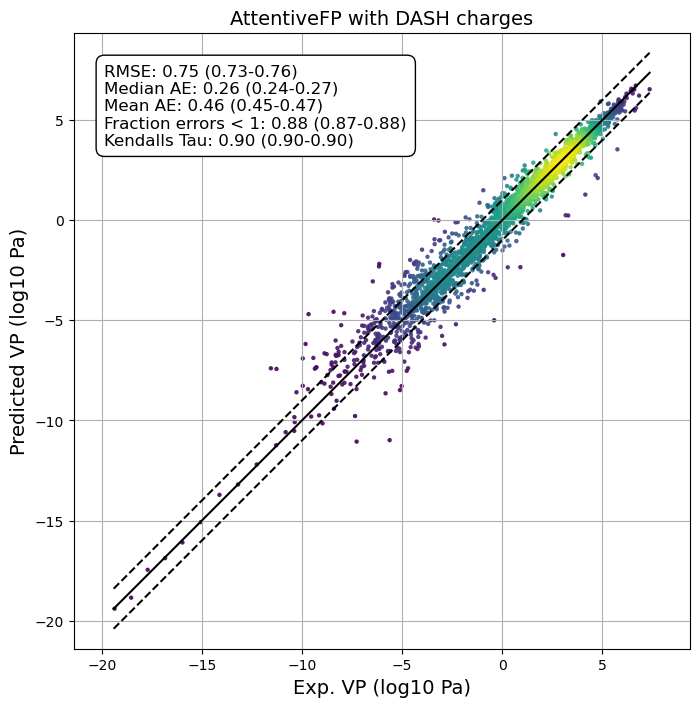

In [54]:
density_plot_single_custom_local(reals = output_repeat[1], predictions = output_repeat[0], molregnos = output_repeat[2], print_stats=True, bounds=None, title='AttentiveFP with DASH charges', print_spearman=False, name=None)

To do: HP opt

In [55]:
#todo, compare to gasteiger: AllChem.ComputeGasteigerCharges(mol)